In [ ]:
!pip install -q -U tensorflow-text==2.7.3
!pip install -q tf-models-official==2.7.0

In [ ]:
!pip install texthero

     |████████████████████████████████| 235 kB 6.8 MB/s 
     |████████████████████████████████| 1.5 MB 42.2 MB/s 
     |████████████████████████████████| 748 kB 39.5 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.util import ngrams
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,Dropout,Dense,Embedding
import re,string,unicodedata
from gensim.models import Word2Vec,KeyedVectors
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import texthero as hero
from texthero import preprocessing as pr
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Data/Financial Sentiment Analysis/data.csv')
print(df.shape)
del df['Unnamed: 0']
df.head()

(5842, 3)


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
df.isnull().sum()/len(df)*100

Sentence     0.0
Sentiment    0.0
dtype: float64

In [ ]:
df['Sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

Positive are 0.6829852790140363 
Negative are 0.8527901403628895 
Neutral are 0.4642245806230743 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


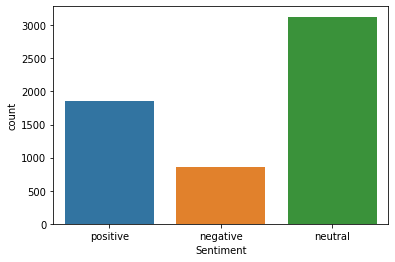

In [ ]:
y=df['Sentiment']
class_1=(len(y)-len(y[y=="positive"]))/len(y)
class_2=(len(y)-len(y[y=="negative"]))/len(y)
class_3=(len(y)-len(y[y=="neutral"]))/len(y)
print(f"Positive are {class_1} ")
print(f"Negative are {class_2} ")
print(f"Neutral are {class_3} ")
sns.countplot(y)

In [ ]:
df['Sentence'][0]

"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."

# Text Preprocessing

In [ ]:
cust_pipes=[pr.fillna,pr.lowercase,pr.remove_punctuation,pr.remove_diacritics,pr.remove_urls,
            pr.remove_brackets,pr.remove_html_tags,pr.remove_stopwords,pr.remove_whitespace
            ]
df['Sentence']=df['Sentence'].pipe(hero.clean,cust_pipes)
df.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon gps s...,positive
1,esi lows 1 50 2 50 bk real possibility,negative
2,last quarter 2010 componenta net sales doubled...,positive
3,according finnish russian chamber commerce maj...,neutral
4,swedish buyout firm sold remaining 22 4 percen...,neutral


In [ ]:
df['Sentence']=hero.preprocessing.remove_digits(df['Sentence'], only_blocks=False)
df.head()


,Sentence,Sentiment
0,geosolutions technology leverage benefon gps s...,positive
1,esi lows bk real possibility,negative
2,last quarter componenta net sales doubled eu...,positive
3,according finnish russian chamber commerce maj...,neutral
4,swedish buyout firm sold remaining percent...,neutral


# Remove words upto 2 characters

In [ ]:
import re
def rem_words(text):
  text=re.sub(r'\b\w{1,2}\b','',text)
  return text
df['Sentence']=df['Sentence'].apply(rem_words)

In [ ]:
df['Sentence'][4]

'swedish buyout firm sold remaining     percent stake almost eighteen months taking company public finland'

# Tokenization

In [ ]:
df['Sentence']=hero.tokenize(df['Sentence'])
df.head()

,Sentence,Sentiment
0,"[geosolutions, technology, leverage, benefon, ...",positive
1,"[esi, lows, real, possibility]",negative
2,"[last, quarter, componenta, net, sales, double...",positive
3,"[according, finnish, russian, chamber, commerc...",neutral
4,"[swedish, buyout, firm, sold, remaining, perce...",neutral


# Lemmatization

In [ ]:
wc =WordNetLemmatizer()
nltk.download('omw-1.4')
def lemma(text):
  words=[wc.lemmatize(i) for i in text]
  return words
df['Sentence']=df['Sentence'].apply(lemma)
df.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


,Sentence,Sentiment
0,"[geosolutions, technology, leverage, benefon, ...",positive
1,"[esi, low, real, possibility]",negative
2,"[last, quarter, componenta, net, sale, doubled...",positive
3,"[according, finnish, russian, chamber, commerc...",neutral
4,"[swedish, buyout, firm, sold, remaining, perce...",neutral


# Join Text

In [ ]:
def combine(text):
  com=' '.join(text)
  return com
df['Sentence']=df['Sentence'].apply(combine)
df.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon gps s...,positive
1,esi low real possibility,negative
2,last quarter componenta net sale doubled eur e...,positive
3,according finnish russian chamber commerce maj...,neutral
4,swedish buyout firm sold remaining percent sta...,neutral


In [ ]:
df['Sentence'][4]

'swedish buyout firm sold remaining percent stake almost eighteen month taking company public finland'

In [ ]:
clas_df=df.groupby('Sentiment').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
clas_df.style.background_gradient(cmap='winter')

,Sentiment,Sentence
1,neutral,3130
2,positive,1852
0,negative,860


In [ ]:
label={'neutral':0,'positive':1,'negative':2}
df['Sentiment'] = df['Sentiment'].apply(lambda x: label[x])
df.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon gps s...,1
1,esi low real possibility,2
2,last quarter componenta net sale doubled eur e...,1
3,according finnish russian chamber commerce maj...,0
4,swedish buyout firm sold remaining percent sta...,0


In [ ]:
!pip install -q -U tensorflow-text==2.7.3
!pip install -q tf-models-official==2.7.0
!pip install transformers

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 495.0 MB 31 kB/s 
     |████████████████████████████████| 1.3 MB 36.8 MB/s 
     |████████████████████████████████| 463 kB 44.5 MB/s 
     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 39.4 MB/s 
     |████████████████████████████████| 90 kB 7.7 MB/s 
     |████████████████████████████████| 352 kB 48.2 MB/s 
     |████████████████████████████████| 1.1 MB 37.2 MB/s 
     |████████████████████████████████| 234 kB 48.6 MB/s 
     |████████████████████████████████| 99 kB 7.5 MB/s 
     |████████████████████████████████| 1.2 MB 31.8 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 47.7 MB 1.6 MB/s 
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 41.0 MB/s 
     |████████████████████████████████| 6.8 MB 32.4 MB/s 
     |█████████████████

In [ ]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
tkn=tokenizer.encode_plus(df['Sentence'].iloc[0],max_length=256,truncation=True,
                          padding='max_length',add_special_tokens=True,return_tensors='tf')
tkn

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,   176,  8209, 24313, 12964,  1116,  2815, 24228, 26181,
        11470,  1320,   176,  3491,  5072,  3558,  2450,  1359,  3403,
         2815,  1661,  3482,  2450,  7503, 20680,  3438,  1207,  3110,
         2595,  2235,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
max_len=256
x_input_id=np.zeros((len(df),max_len))
x_attn_mask=np.zeros((len(df),max_len))

In [ ]:
x_input_id.shape,x_attn_mask.shape

((5842, 256), (5842, 256))

In [ ]:
def data(df,ids,masks,tokenizer):
  for i,text in enumerate(df['Sentence']):
    token=tokenizer.encode_plus(text,max_length=max_len,truncation=True,padding='max_length',
                                add_special_tokens=True,return_tensors='tf')
    ids[i, :]=token.input_ids
    masks[i, :]=token.attention_mask
  return ids,masks

In [ ]:
x_input_id,x_attn_mask=data(df,x_input_id,x_attn_mask,tokenizer)

In [ ]:
labels=np.zeros((len(df),3))
labels[np.arange(len(df)),df['Sentiment'].values]=1
labels

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
data=tf.data.Dataset.from_tensor_slices((x_input_id,x_attn_mask,labels))
data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [ ]:
def mapfunc(input_ids,attn_masks,labels):
  return {
      'input_ids':input_ids,
      'attention_mask':attn_masks
  },labels

In [ ]:
data=data.map(mapfunc)
data.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [ ]:
from transformers import TFBertModel
data=data.shuffle(10000).batch(16,drop_remainder=True)
train_size=int((len(df)//16)*0.8)
train=data.take(train_size)
val=data.skip(train_size)

In [ ]:
bert=TFBertModel.from_pretrained('bert-base-cased')
input_ids=tf.keras.layers.Input(shape=(256,),name='input_ids',dtype='int32')
attention_masks=tf.keras.layers.Input(shape=(256,),name='attention_mask',dtype='int32')
bert_layer=bert.bert(input_ids,attention_mask=attention_masks)[1]
denses=tf.keras.layers.Dense(512,activation='relu',name='dense_layer')(bert_layer)
output_layer=tf.keras.layers.Dense(3,activation='softmax',name='output_layer')(denses)
model=tf.keras.Model(inputs=[input_ids,attention_masks],outputs=output_layer)
model.summary()

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

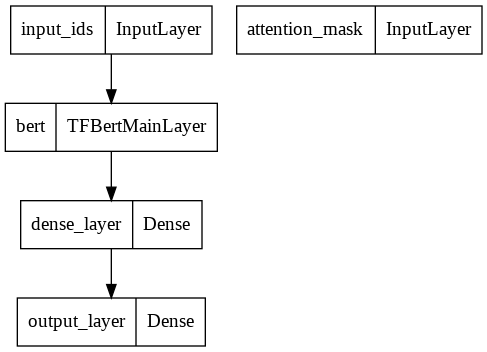

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
optim=tf.keras.optimizers.Adam(learning_rate=1e-5,decay=1e-6)
loss=tf.keras.losses.CategoricalCrossentropy()
acc=tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optim,loss=loss,metrics=[acc])
hist=model.fit(train,validation_data=val,epochs=5)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
292/292 [==============================] - ETA: 0s - loss: 0.8007 - accuracy: 0.6383WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe2a4b977a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
292/292 [==============================] - 268s 882ms/step - loss: 0.8007 - accuracy: 0.6383 - val_loss: 0.5455 - val_accuracy: 0.7654
Epoch 2/5
292/292 [==============================] - 257s 878ms/step - loss: 0.5333 - accuracy: 0.7568 - val_loss: 0.3816 - val_accuracy: 0.8339
Epoch 3/5
292/292 [==============================] - 256s 877ms/step - loss: 0.4292 - accuracy: 0.8044 - val_loss: 0.3283 - val_accuracy: 0.8433
Epoch 4/5
292/292 [==============================] - 256s 877ms/step - loss: 0.3263 - accuracy: 0.8440 - val_loss: 0.2264 - val_accuracy: 0.8776
Epoch 5/5
292/292 [==============================] - 256s 878ms/step - loss: 0.2821 - a

In [ ]:
history_dict = hist.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


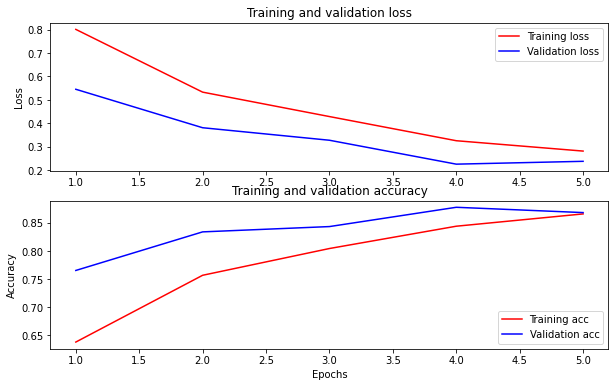

In [ ]:
history_dict = hist.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')